# Comparison of exact and approximate form-factor functions 

In this notebook, we generate comparison plots for the exact and approximate form factor functions. We also save the values of the functions for $1000$ masses from $10^{-4}$ GeV to $10^{4}$ GeV so that we don't need to compute them later.

In [1]:
#For numerics
import numpy as np

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For setting root path
import sys
import os

root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if root not in sys.path:
    sys.path.append(root)
    
if os.getcwd() != root:
    os.chdir(root)

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

#Form factor functions
from lfv_lepton_observables.formulae.form_factor_functions import f_plus, f_minus, g_plus, g_minus
from lfv_lepton_observables.formulae.form_factor_functions_approx import (f_plus_approx,
                                                                          f_minus_approx,
                                                                          g_plus_approx,
                                                                          g_minus_approx,
                                                                          f_plus_large_m,
                                                                          f_minus_large_m)
from phys.constants import me, mm, mt, ml

Let us begin by generating the values of the form-factor function $f(x_i, x_j, x_k)$ over a large range of parameters. In the text, we note that for $i = j$, $f(x_i, x_i, x_j) \equiv g(x_i, x_j)$ as defined in the text. This is already coded under the hood, so we just evaluate $f$ here.

In [2]:
#names of leptons (in TeX)
leptons = ['e', '\\mu', '\\tau']

#diagrams of the form (i, j, k) representing a dipole vertex with external i,j and internal k
diagrams = [(0, 0, 0), (0, 0, 1), (0, 0, 2), #electron dipole moments
            (1, 0, 0), (1, 0, 1), (1, 0, 2), #\mu \rightarrow e \gamma
            (1, 1, 0), (1, 1, 1), (1, 1, 2), #muon dipole moments
            (2, 0, 0), (2, 0, 1), (2, 0, 2), #\tau \rightarrow \e \gamma
            (2, 1, 0), (2, 1, 1), (2, 1, 2), #\tau \rightarrow \mu \gamma
            (2, 2, 0), (2, 2, 1), (2, 2, 2) #tau dipole moments
           ]

#labels for the diagrams 
def diagram_label(diagram):
    i, j, k = diagram
    
    #for i =/= j, the label corresponds to li -> lj gamma decay rate 
    if i < j:
        j, i = i, j
    if i > j:
        label = f'${leptons[i]}\\stackrel{{{leptons[k]}}}{{\\longrightarrow}}{leptons[j]}\\gamma$'
    #for i = j, the label corresponds to lepton dipole moments, signified by li lj \gamma (lk)
    elif i == j:
        label = f'${leptons[i]} {leptons[j]}\\gamma ~ ({leptons[k]})$'
    return label

#Check over a large range of masses
m = np.geomspace(1e-4, 1e4, 1000)
u = np.complex128([_/m for _ in ml])
x = np.complex128([(m/_)**2 for _ in ml])

#f(xi, xj, xk) relevant form form-factor F2 (f_{\pm}(xi, xi, xj) = g_{\pm}(xi, xj))
f2p = {}
f2m = {}

#approximations for the above
f2p_approx = {}
f2m_approx = {}

# f(xi, -xj, xk), relevant for form-factor F3 
f3p = {}
f3m = {}

# f(xi, -xj, xk), relevant for form-factor F3 
f3p_approx = {}
f3m_approx = {}

labels = {}
for diagram in diagrams:
    i, j, k = diagram
    f2p_approx[diagram] = f_plus_approx(i, j, k)(u[i], u[j], u[k])
    f2m_approx[diagram] = f_minus_approx(i, j, k)(u[i], u[j], u[k])

    f3p_approx[diagram] = f_plus_approx(i, j, k)(u[i], -u[j], u[k])
    f3m_approx[diagram] = f_minus_approx(i, j, k)(u[i], -u[j], u[k])
    
    f2p[diagram] = np.where(x[i] < (1e8 if i == j else 1e6), #this is ham-fisted in here to fix precision errors
                            f_plus(u[i], u[j], u[k]),
                            f_plus_approx(i, j, k)(u[i], u[j], u[k]))
    f2m[diagram] = np.where(x[i] < (1e8 if i == j else 1e6),
                            f_minus(u[i], u[j], u[k]),
                            f_minus_approx(i, j, k)(u[i], u[j], u[k]))
    
    f3p[diagram] = np.where(x[i] < (1e8 if i == j else 1e6),
                            f_plus(u[i], -u[j], u[k]),
                            f_plus_approx(i, j, k)(u[i], -u[j], u[k]))
    f3m[diagram] = np.where(x[i] < (1e8 if i == j else 1e6),
                            f_minus(u[i], -u[j], u[k]),
                            f_minus_approx(i, j, k)(u[i], -u[j], u[k]))
    
    labels[diagram] = diagram_label(diagram)

## Comparisons for $\ell_i \rightarrow \ell_j\gamma$ form factors

First, we compute the relevant form factors for the LFV lepton decays $\ell_i \rightarrow \ell_j\gamma$ through an internal $\ell_k$. We define a helper function for comparing the exact and approximate functions of a given diagram:

In [3]:
def relative_error(exact, approx):
        return np.abs((exact-approx)/exact)

#For our purposes, we will only compare f2p and f2m... f3p and f3m are mostly the same
def compare(relevant_diagrams, part = None, sign = '+'):
    assert part in [None, 'real', 'imag', 'abs']
    assert sign in ['+', '-']
    
    if sign == '+':
        f = f2p
        f_approx = f2p_approx
        ylabel = 'f_+(\\mu_i, \\mu_j, \\mu_k)'
    elif sign == '-':
        f = f2m
        f_approx = f2m_approx
        ylabel = 'f_-(\\mu_i, \\mu_j, \\mu_k)'
    
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 1, height_ratios=[2, 1], hspace = 0)

    func_ax = fig.add_subplot(gs[0])
    error_ax = fig.add_subplot(gs[1], sharex=func_ax)
    
    #Top plot 
    for idx, diagram in enumerate(relevant_diagrams):
        i, j, k = diagram
        
        #typically, functions are written in terms of x[l] for the heaviest lepton l
        x_ax = x[i] if i >= k else x[k]   
        
        if part == 'imag':
            #Exact function
            func_ax.plot(x_ax,
                         np.imag(f[diagram]),
                         color = colors[idx],
                         label = labels[diagram]
                        )
            #Approximate function
            func_ax.plot(x_ax,
                         np.imag(f_approx[diagram]),
                         color = 'black',
                         linestyle = 'dotted'
                        )
        elif part == 'abs':
            #Exact function
            func_ax.plot(x_ax,
                         np.abs(f[diagram]),
                         color = colors[idx],
                         label = labels[diagram]
                        )
            #Approximate function
            func_ax.plot(x_ax,
                         np.abs(f_approx[diagram]),
                         color = 'black',
                         linestyle = 'dotted'
                        )
        else:
            
            #Exact function
            func_ax.plot(x_ax,
                         np.real(f[diagram]),
                         color = colors[idx],
                         label = labels[diagram]
                        )
            #Approximate function
            func_ax.plot(x_ax,
                         np.real(f_approx[diagram]),
                         color = 'black',
                         linestyle = 'dotted'
                        )
            
    #Dummy point to label approximation on axis
    func_ax.plot([1e10], color = 'black', linestyle = 'dotted', label = '$\\textrm{approx}$')
    
    #Legend
    func_ax.legend(fancybox=False,
                   facecolor = 'white',
                   edgecolor = 'black',
                   framealpha = 1,
                   fontsize = 12,
                   loc = 'upper right'
                  )
    
    #Axis specifications
    func_ax.grid()
        
    if part == 'imag':
        func_ax.set_ylabel(f'$\\textrm{{Im}}\\{{{ylabel}\\}}$', fontsize = 14)
    elif part == 'real':
        func_ax.set_ylabel(f'$\\textrm{{Re}}\\{{{ylabel}\\}}$', fontsize = 14)
    elif part == 'abs':
        func_ax.set_ylabel(f'$\\left|{ylabel}\\right|$', fontsize = 14)
    else:
        func_ax.set_ylabel(f'${ylabel}$', fontsize = 14)

    func_ax.tick_params(which = 'both', direction = 'in', labelbottom = False)

    #Bottom plot
    for idx, diagram in enumerate(relevant_diagrams):
        i,j,k = diagram
        
        x_ax = x[i] if i >= k else x[k]
        idx_label = 'i' if i >= k else ('j' if i == j else 'k')

        if part == 'imag':
            error_ax.plot(x_ax,
                          relative_error(np.imag(f[diagram]), np.imag(f_approx[diagram])),
                          color = colors[idx],
                         )
        elif part == 'real':
            error_ax.plot(x_ax,
                          relative_error(np.real(f[diagram]), np.real(f_approx[diagram])),
                          color = colors[idx],
                         )
        elif part == 'abs':
            error_ax.plot(x_ax,
                          relative_error(np.abs(f[diagram]), np.abs(f_approx[diagram])),
                          color = colors[idx],
                         )
        else:
            error_ax.plot(x_ax,
                          relative_error(f[diagram], f_approx[diagram]),
                          color = colors[idx],
                         )

    #Axis specifications
    error_ax.grid()
    error_ax.set_xlabel(f'$x_{idx_label} = m_\\varphi^2/m_{idx_label}^2$', fontsize = 14)
    error_ax.set_xscale('log')
    
    error_ax.set_ylabel("$\\textrm{rel. errors}$", fontsize = 14)
    error_ax.set_yscale('log')
    error_ax.tick_params(which = 'both', direction = 'in')

    return func_ax, error_ax

### $i = k > j$:

In [4]:
relevant_diagrams = [(1, 0, 1), (2, 0, 2), (2, 1, 2)]

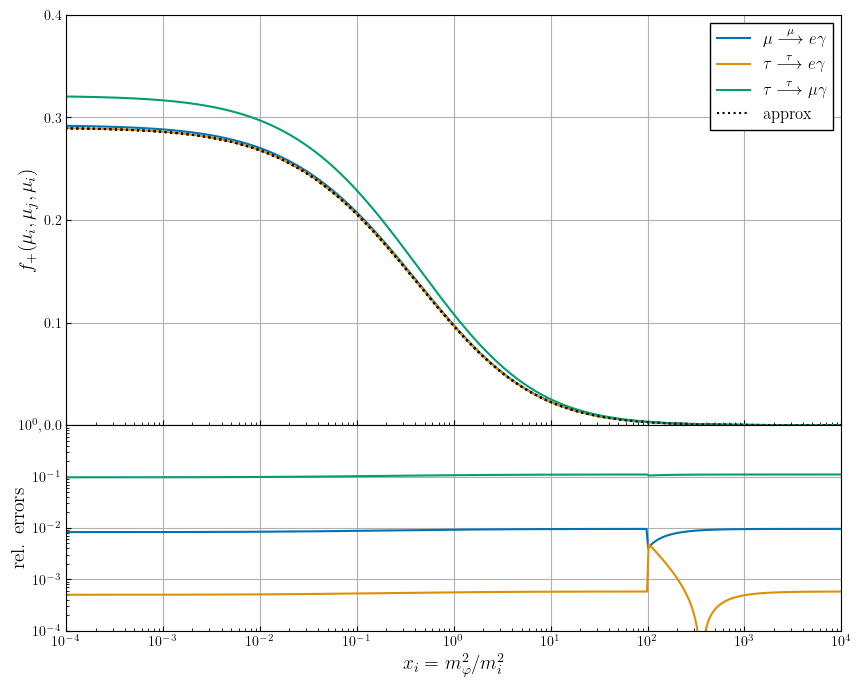

In [5]:
func_ax, error_ax = compare(relevant_diagrams, sign = '+')
func_ax.set_ylim(0, 0.4)
func_ax.set_yticks([0.1, 0.2, 0.3, 0.4])
func_ax.set_ylabel('$f_+(\\mu_i, \\mu_j, \\mu_i)$')

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/f_plus_same_i_k.pdf', format = 'pdf')

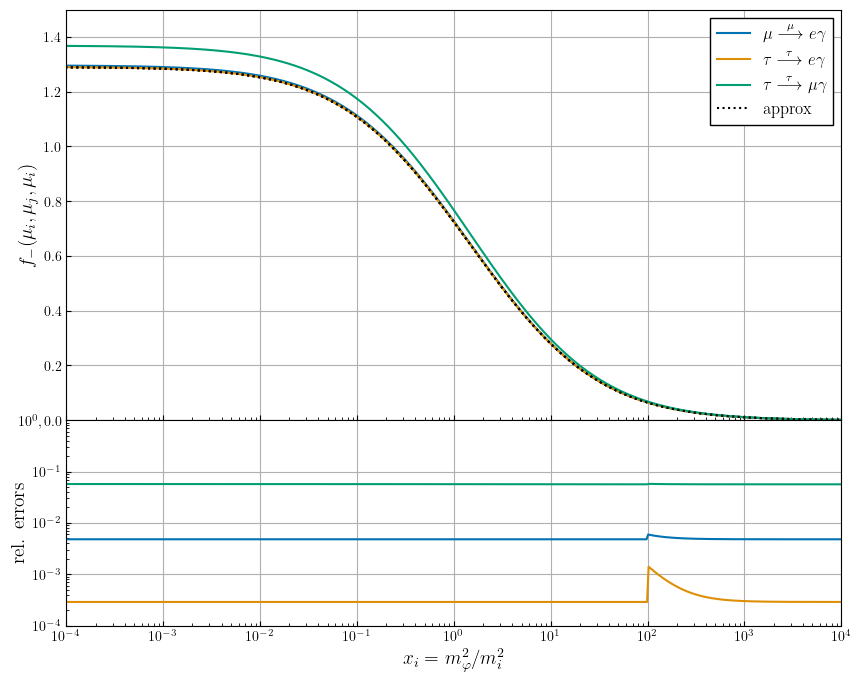

In [6]:
func_ax, error_ax = compare(relevant_diagrams, sign = '-')
func_ax.set_ylim(0, 1.5)
func_ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
func_ax.set_ylabel('$f_-(\\mu_i, \\mu_j, \\mu_i)$')

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(3.22e-5, -0.02, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/f_minus_same_i_k.pdf', format = 'pdf')

### $i > j, k$:

In [7]:
relevant_diagrams = [(1, 0, 0), (2, 0, 0), (2, 0, 1), (2, 1, 0), (2, 1, 1)]

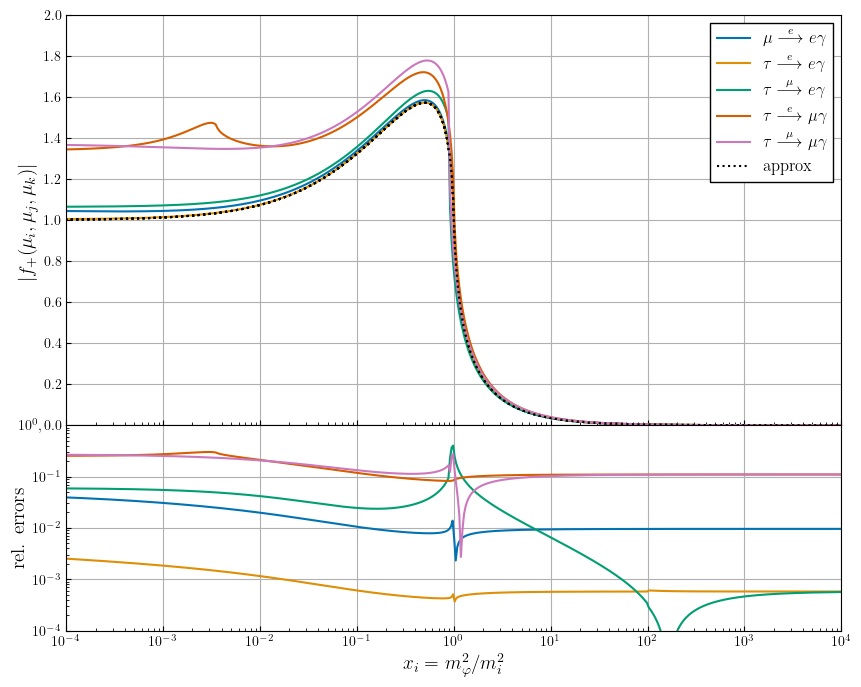

In [8]:
func_ax, error_ax = compare(relevant_diagrams, part = 'abs', sign = '+')
func_ax.set_ylim(0, 2)
func_ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(3.22e-5, -0.021, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/abs_f_plus_large_i.pdf', format = 'pdf')

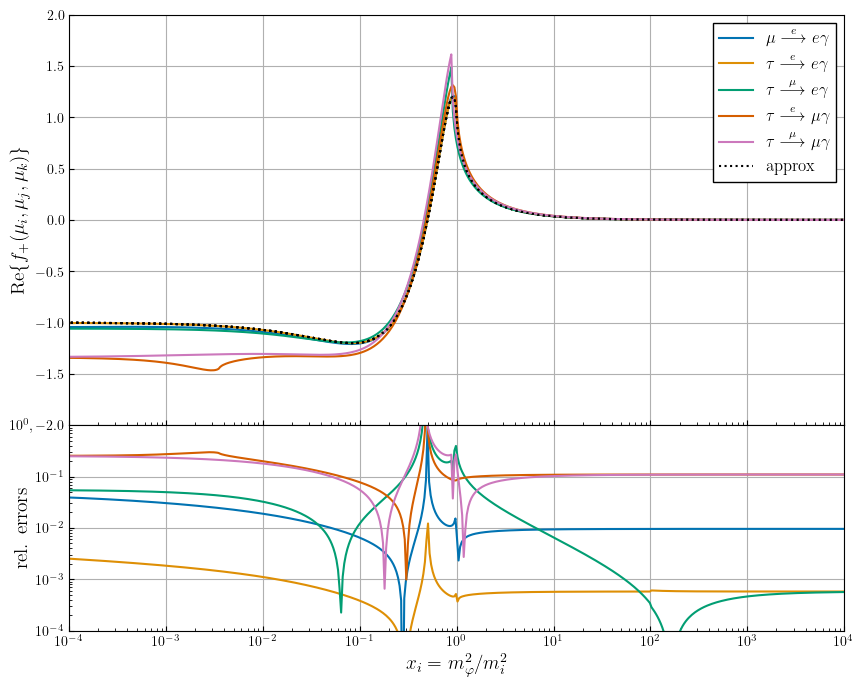

In [9]:
func_ax, error_ax = compare(relevant_diagrams, part = 'real', sign = '+')
func_ax.set_ylim(-2, 2)
func_ax.set_yticks([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(2.45e-5, -2.045, "$10^{0}, -2.0$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/Re_f_plus_large_i.pdf', format = 'pdf')

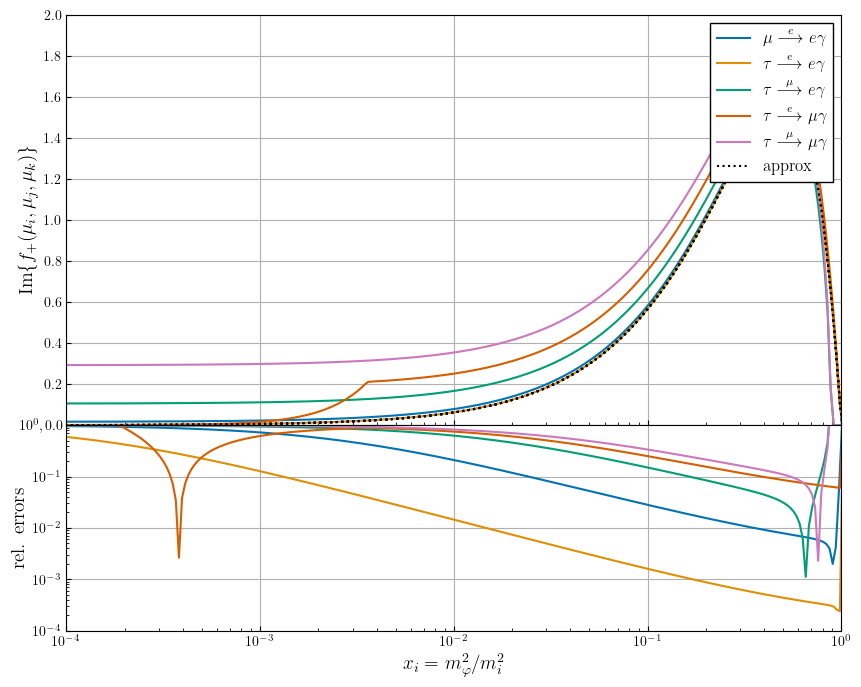

In [10]:
func_ax, error_ax = compare(relevant_diagrams, part = 'imag', sign = '+')
func_ax.set_ylim(0, 2)
func_ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(5.74e-5, -0.024, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-4, 1)
func_ax.set_xlim(1e-4, 1)
error_ax.set_xlim(1e-4, 1)

plt.savefig(root + '/figures/appendix/Im_f_plus_large_i.pdf', format = 'pdf')

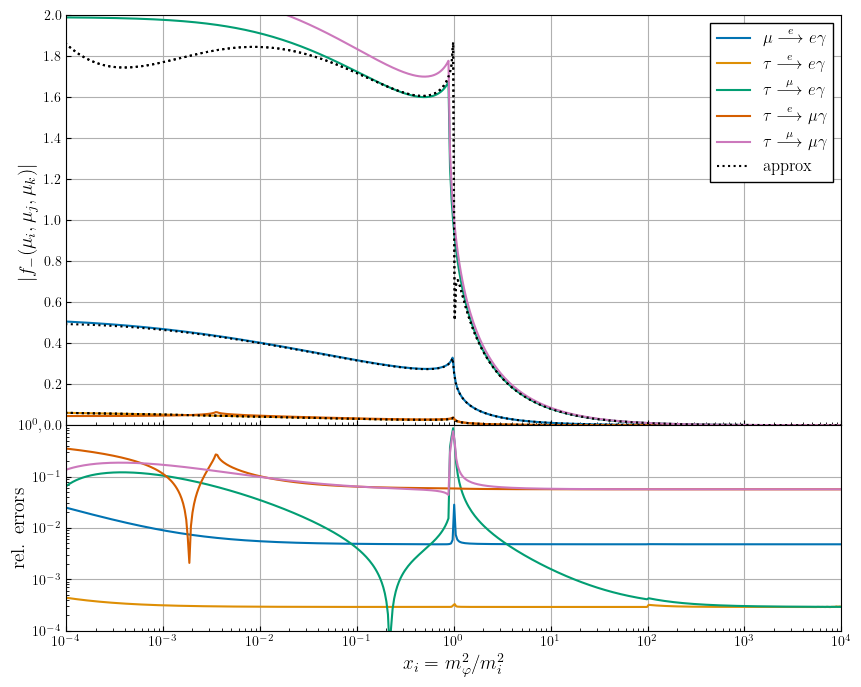

In [11]:
func_ax, error_ax = compare(relevant_diagrams, part = 'abs', sign = '-')
func_ax.set_ylim(0, 2)
func_ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(3.22e-5, -0.021, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/abs_f_minus_large_i.pdf', format = 'pdf')

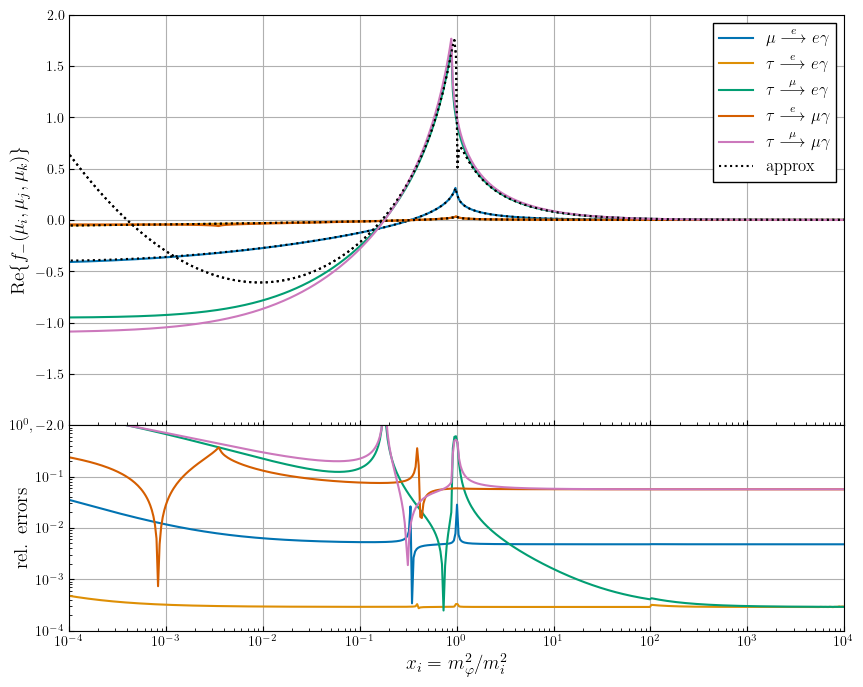

In [12]:
func_ax, error_ax = compare(relevant_diagrams, part = 'real', sign = '-')
func_ax.set_ylim(-2, 2)
func_ax.set_yticks([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(2.45e-5, -2.045, "$10^{0}, -2.0$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/Re_f_minus_large_i.pdf', format = 'pdf')

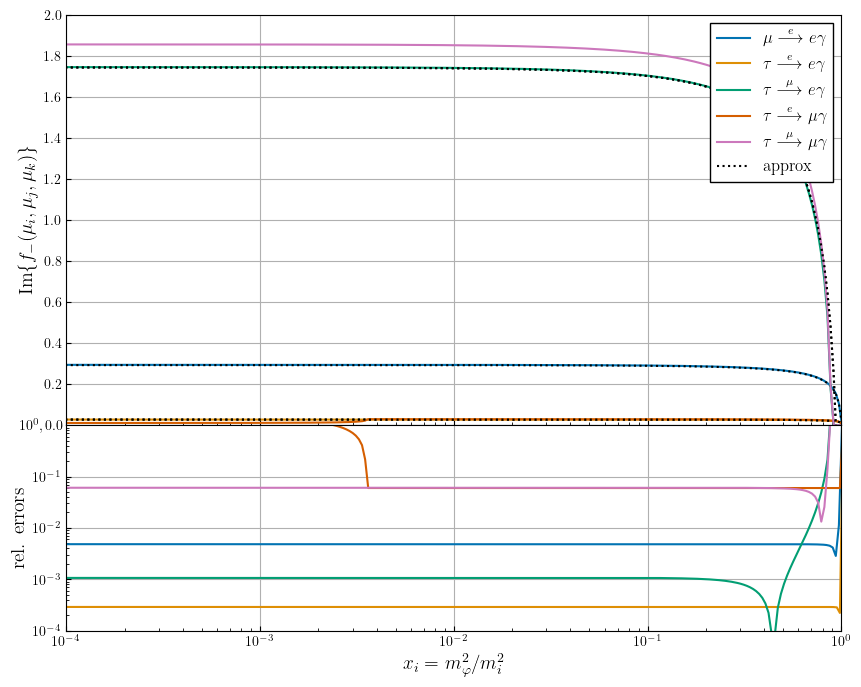

In [13]:
func_ax, error_ax = compare(relevant_diagrams, part = 'imag', sign = '-')
func_ax.set_ylim(0, 2)
func_ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(5.74e-5, -0.024, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-4, 1)
func_ax.set_xlim(1e-4, 1)
error_ax.set_xlim(1e-4, 1)

plt.savefig(root + '/figures/appendix/Im_f_minus_large_i.pdf', format = 'pdf')

### $k > i > j$:

In [14]:
relevant_diagrams = [(1, 0, 2)]

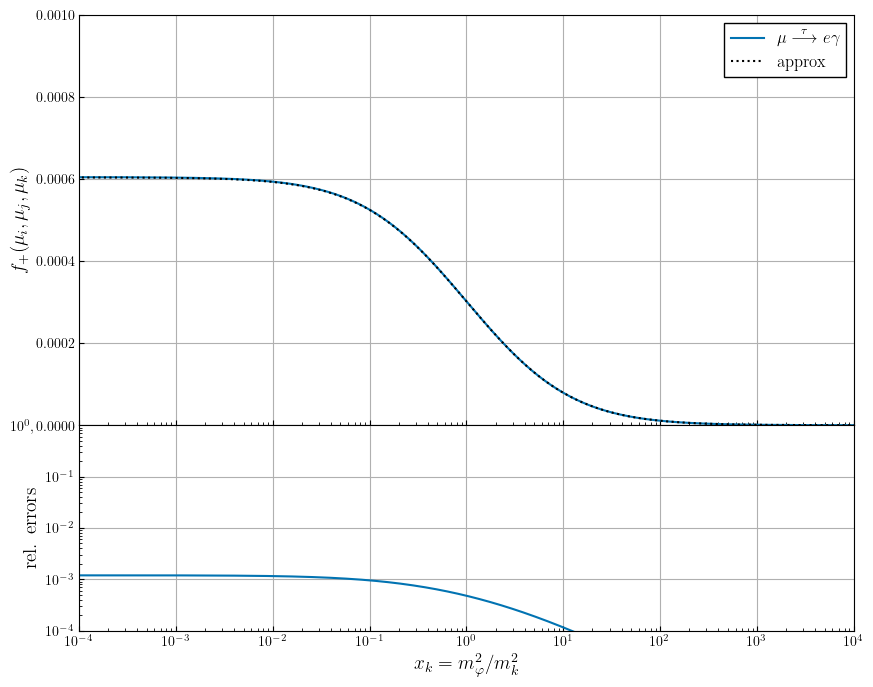

In [15]:
func_ax, error_ax = compare(relevant_diagrams, sign = '+')
func_ax.set_ylim(0, 0.001)
func_ax.set_yticks([0.0002, 0.0004, 0.0006, 0.0008, 0.001])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(2e-5, -0.000015, "$10^{0}, 0.0000$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)
error_ax.set_xlabel('$x_k = m_\\varphi^2/m_k^2$')

plt.savefig(root + '/figures/appendix/f_plus_large_k.pdf', format = 'pdf')

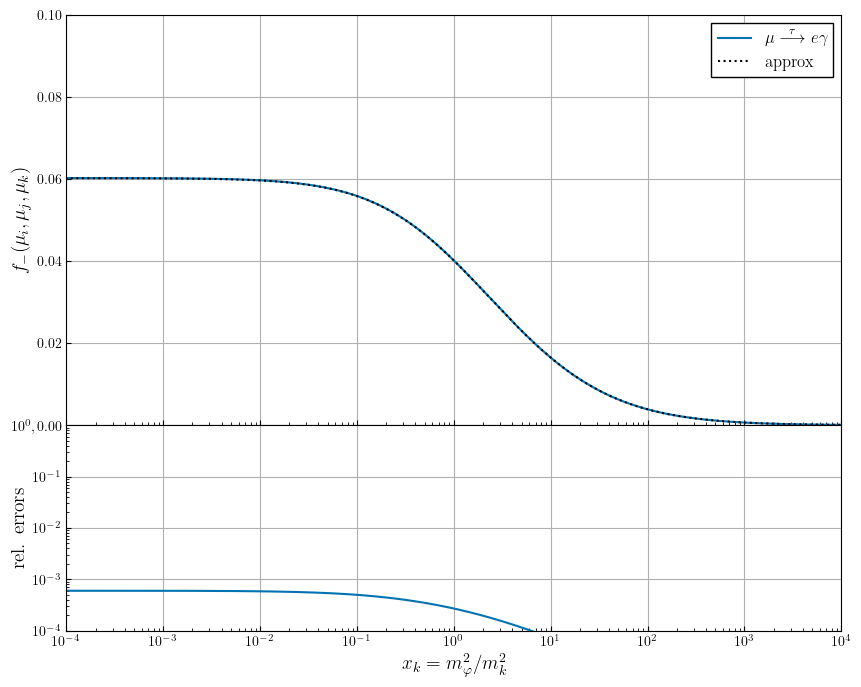

In [16]:
func_ax, error_ax = compare(relevant_diagrams, sign = '-')
func_ax.set_ylim(0, 0.1)
func_ax.set_yticks([0.02, 0.04, 0.06, 0.08, 0.1])

error_ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])

func_ax.text(2.75e-5, -0.0015, "$10^{0}, 0.00$")

error_ax.set_ylim(1e-4, 1)
error_ax.set_xlim(1e-4, 1e4)
error_ax.set_xlabel('$x_k = m_\\varphi^2/m_k^2$')

plt.savefig(root + '/figures/appendix/f_minus_large_k.pdf', format = 'pdf')

## Comparisons for lepton dipole moment form factors

Now, we compute the relevant form factors for the dipole moments of the leptons. We only do this for $i > j$ and $i < j$, because for $i = j$, the expression for $g(x_i, x_i)$ is exact.

### $i > j$:

In [17]:
relevant_diagrams = [(1, 1, 0), (2, 2, 0), (2, 2, 1)]

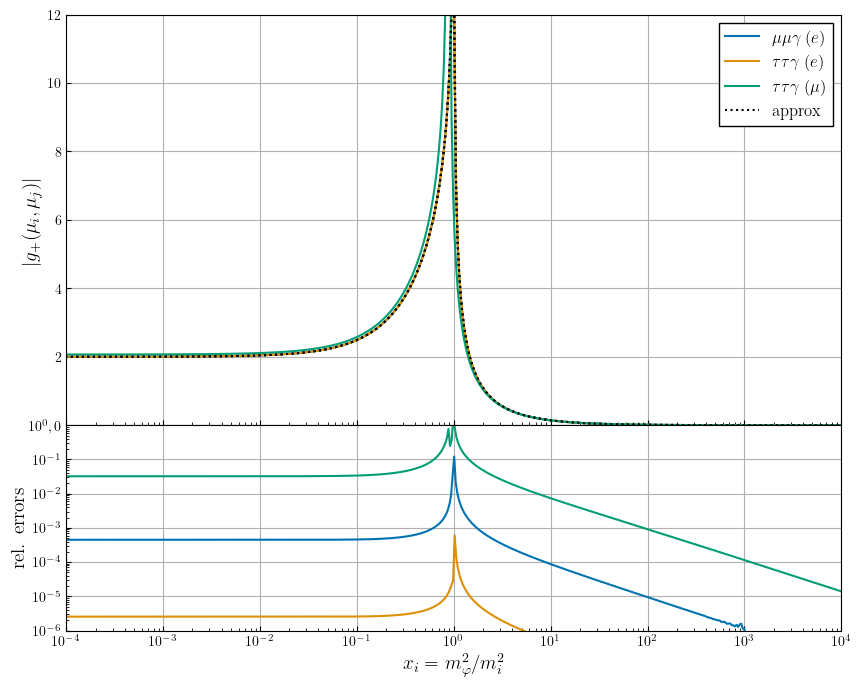

In [18]:
func_ax, error_ax = compare(relevant_diagrams, part = 'abs', sign = '+')
func_ax.set_ylim(0, 12)
#func_ax.set_yscale('log')
func_ax.set_yticks([2, 4, 6, 8, 10, 12])
func_ax.set_ylabel('$\\left|g_+(\\mu_i, \\mu_j)\\right|$')
func_ax.text(4.1e-5, -0.18, "$10^{0}, 0$")

error_ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

#func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-6, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/abs_g_plus_small_j.pdf', format = 'pdf')

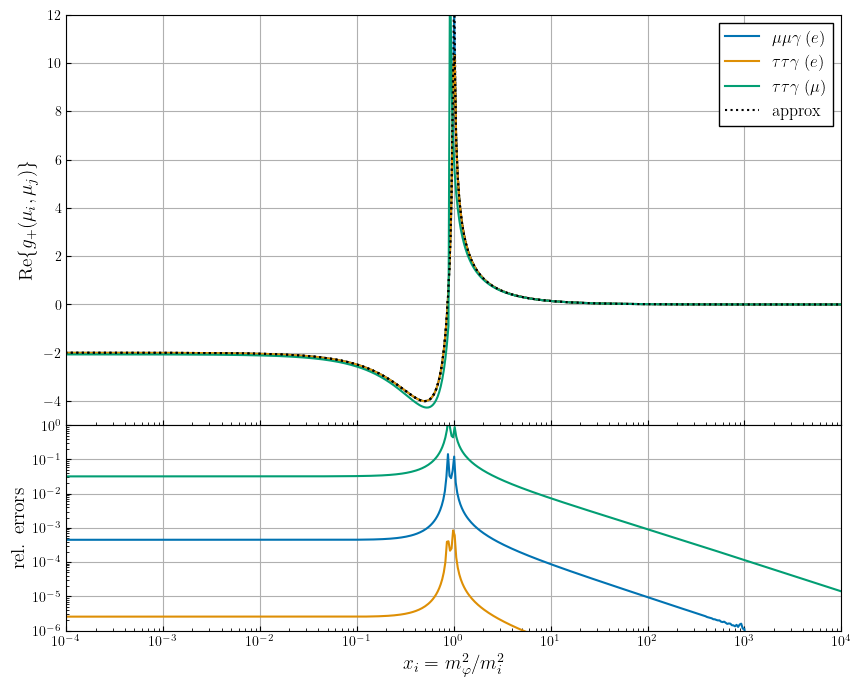

In [19]:
func_ax, error_ax = compare(relevant_diagrams, part = 'real', sign = '+')
func_ax.set_ylim(-5, 12)
#func_ax.set_yscale('log')
#func_ax.set_yticks([2, 4, 6, 8, 10, 12, 14])
func_ax.set_ylabel('$\\textrm{Re}\\{g_+(\\mu_i, \\mu_j)\\}$')
#func_ax.text(4.1e-5, -0.2, "$10^{0}, 0$")

error_ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

#func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-6, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/Re_g_plus_small_j.pdf', format = 'pdf')

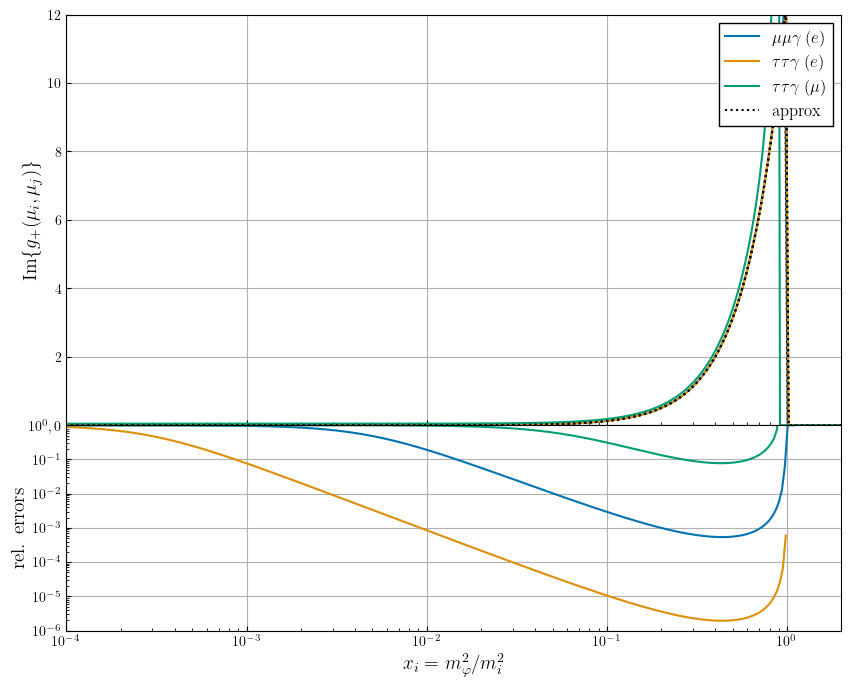

In [20]:
func_ax, error_ax = compare(relevant_diagrams, part = 'imag', sign = '+')
func_ax.set_ylim(0, 12)
#func_ax.set_yscale('log')
func_ax.set_yticks([2, 4, 6, 8, 10, 12])
func_ax.set_ylabel('$\\textrm{Im}\\{g_+(\\mu_i, \\mu_j)\\}$')
func_ax.text(6.2e-5, -0.18, "$10^{0}, 0$")

error_ax.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

#func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-6, 1)
error_ax.set_xlim(1e-4, 2)

plt.savefig(root + '/figures/appendix/Im_g_plus_small_j.pdf', format = 'pdf')

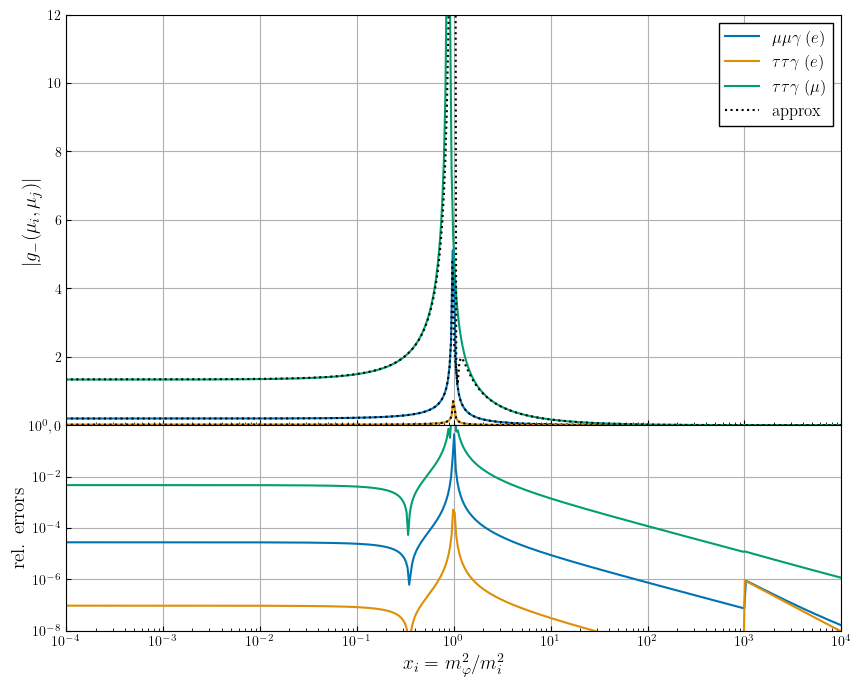

In [21]:
func_ax, error_ax = compare(relevant_diagrams, part = 'abs', sign = '-')
func_ax.set_ylim(0, 12)
#func_ax.set_yscale('log')
func_ax.set_yticks([2, 4, 6, 8, 10, 12])
func_ax.set_ylabel('$\\left|g_-(\\mu_i, \\mu_j)\\right|$')
func_ax.text(4.1e-5, -0.18, "$10^{0}, 0$")

error_ax.set_yticks([1e-8, 1e-6, 1e-4, 1e-2])

#func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-8, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/abs_g_minus_small_j.pdf', format = 'pdf')

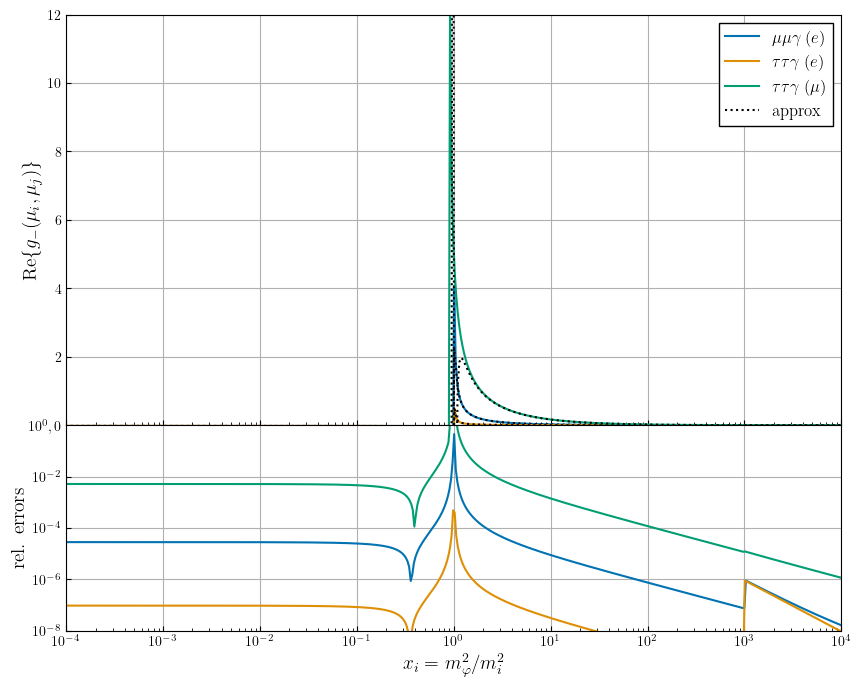

In [22]:
func_ax, error_ax = compare(relevant_diagrams, part = 'real', sign = '-')
func_ax.set_ylim(0, 12)
#func_ax.set_yscale('log')
func_ax.set_yticks([2, 4, 6, 8, 10, 12])
func_ax.set_ylabel('$\\textrm{Re}\\{g_-(\\mu_i, \\mu_j)\\}$')
func_ax.text(4.1e-5, -0.18, "$10^{0}, 0$")

error_ax.set_yticks([1e-8, 1e-6, 1e-4, 1e-2])

#func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-8, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/Re_g_minus_small_j.pdf', format = 'pdf')

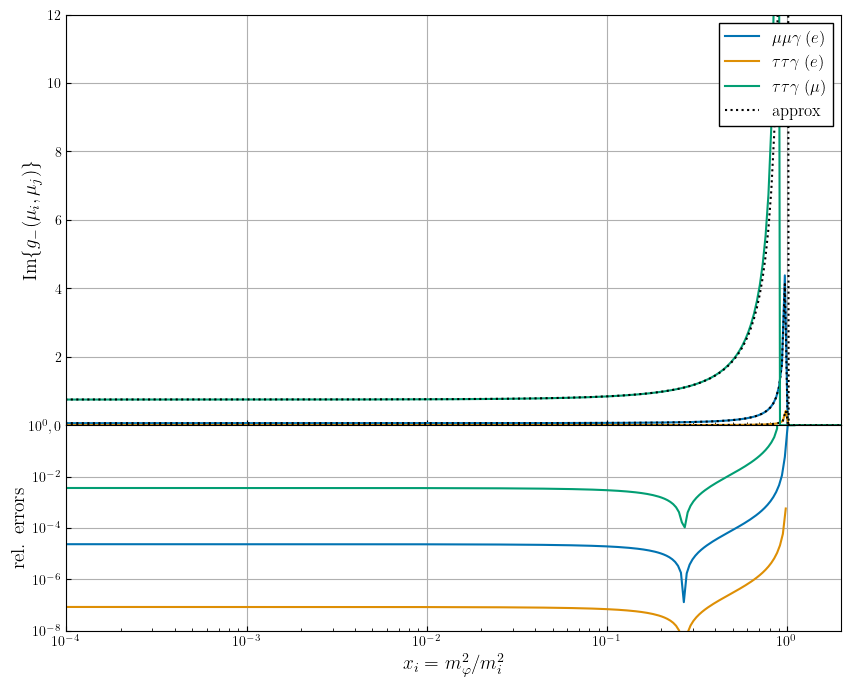

In [23]:
func_ax, error_ax = compare(relevant_diagrams, part = 'imag', sign = '-')
func_ax.set_ylim(0, 12)
#func_ax.set_yscale('log')
func_ax.set_yticks([2, 4, 6, 8, 10, 12])
func_ax.set_ylabel('$\\textrm{Im}\\{g_-(\\mu_i, \\mu_j)\\}$')
func_ax.text(6.2e-5, -0.18, "$10^{0}, 0$")

error_ax.set_yticks([1e-8, 1e-6, 1e-4, 1e-2])

#func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-8, 1)
error_ax.set_xlim(1e-4, 2)

plt.savefig(root + '/figures/appendix/Im_g_minus_small_j.pdf', format = 'pdf')

### $i < j$:

In [24]:
relevant_diagrams = [(0, 0, 1), (0, 0, 2), (1, 1, 2)]

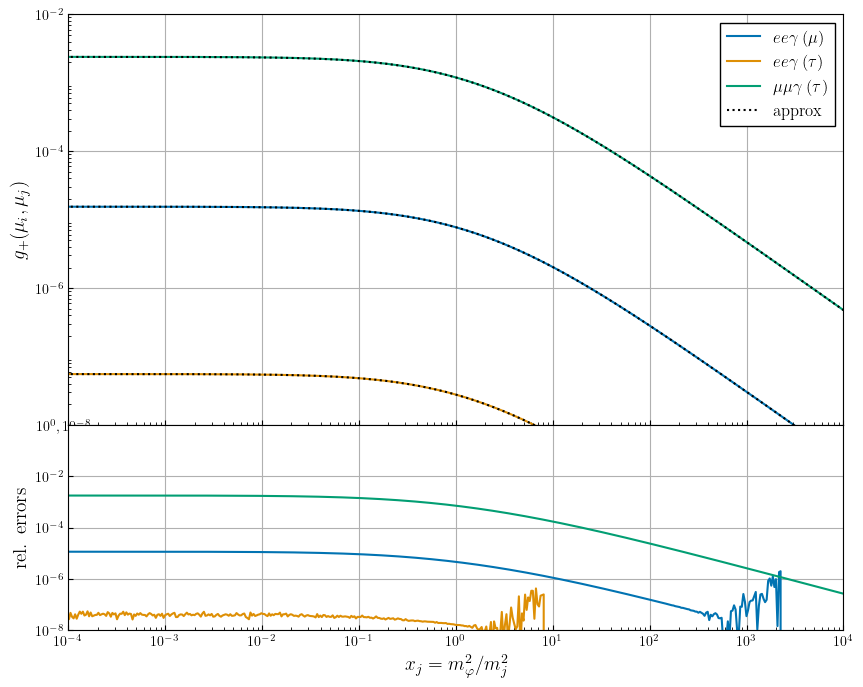

In [25]:
func_ax, error_ax = compare(relevant_diagrams, sign = '+')
func_ax.set_ylim(1e-8, 0.01)
func_ax.set_yscale('log')
#func_ax.set_yscale('log')
func_ax.set_yticks([1e-6,1e-4,1e-2])
func_ax.set_ylabel('$g_+(\\mu_i, \\mu_j)$')
func_ax.text(4.7e-5, 8.3e-9, "$10^{0}, 10^{-8}$")

error_ax.set_yticks([1e-8, 1e-6, 1e-4, 1e-2])

#func_ax.text(3.22e-5, -0.0042, "$10^{0}, 0.0$")

error_ax.set_ylim(1e-8, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/g_plus_large_j.pdf', format = 'pdf')

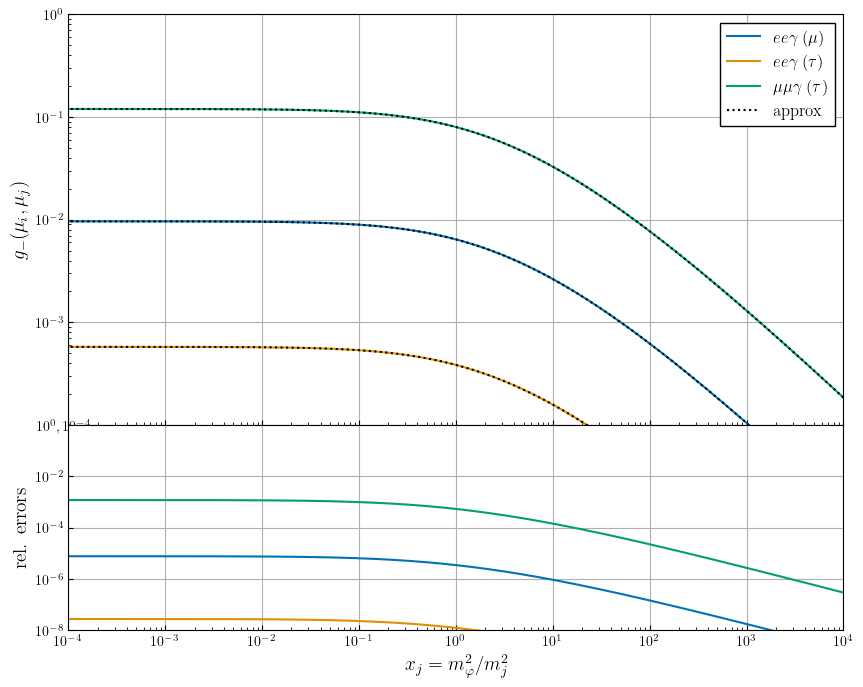

In [26]:
func_ax, error_ax = compare(relevant_diagrams, sign = '-')
func_ax.set_ylim(1e-4, 1)
func_ax.set_yscale('log')

func_ax.set_yticks([1e-3,1e-2,1e-1,1e0])
func_ax.set_ylabel('$g_-(\\mu_i, \\mu_j)$')
func_ax.text(4.7e-5, 8.8e-5, "$10^{0}, 10^{-4}$")

error_ax.set_yticks([1e-8, 1e-6, 1e-4, 1e-2])


error_ax.set_ylim(1e-8, 1)
error_ax.set_xlim(1e-4, 1e4)

plt.savefig(root + '/figures/appendix/g_minus_large_j.pdf', format = 'pdf')